#####  Area Averaging using UXarray
- Read MPAS diag data
- compute the area average overbounding box 
- create wind speed x-axis: magnitude, y-axis: logarithmic pressure)line plot
 
Ming Ge May 2025

In [1]:
import numpy as np
import uxarray as ux
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.ticker import (NullFormatter, ScalarFormatter)
from holoviews import opts
import holoviews as hv
# Tell HoloViews (and hvplot) to use the Matplotlib backend for rendering plots
hv.extension( "matplotlib")

#### Read grid and data using uxarray

In [2]:
dir_data = "/glade/campaign/mmm/c3we/mingge/MPAS_PROJ/mpas_tutorial/240-48km_variable/"
flnm_grid = dir_data + "SouthAmerica.init.nc"
flnm_data = dir_data + "diag.2014-09-14_12.00.00.nc"

uxds = ux.open_dataset(flnm_grid, flnm_data)
uxgrid = uxds.uxgrid 

#### Define a domain centered at specific lat-lon

:Overlay
   .Path.I      :Path   [Longitude,Latitude]
   .States.I    :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
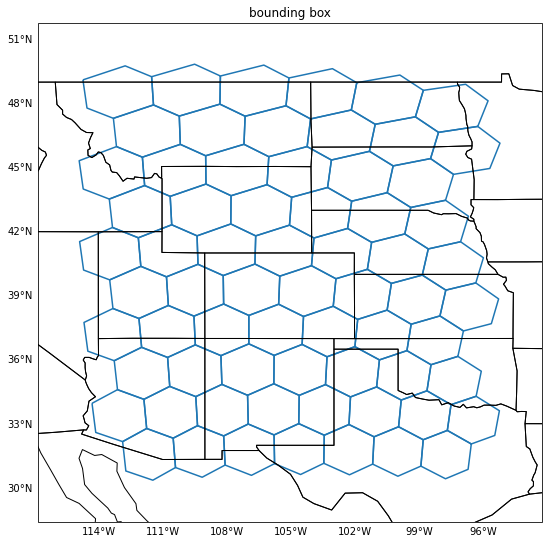

In [3]:
cenlat  = 40
cenlon  = -105
proj = ccrs.PlateCarree() #(central_latitude=cenlat, central_longitude=cenlon)
 
lon_bounds = (cenlon - 10, cenlon + 10)
lat_bounds = (cenlat - 10, cenlat + 10)

bbox_subset = uxgrid.subset.bounding_box(lon_bounds = lon_bounds, lat_bounds=lat_bounds)
bbox_subset.plot.edges(backend='matplotlib', 
                       height=500, width=750,
                       title="bounding box",
                       projection=proj , 
                       features=["borders", "coastline","states"])  


#### Calculate the area-averaged wind speed

In [4]:
height_1d = [50,100,200,250, 500,700,850,925]
n_lev = len(height_1d)
n_cell = len(uxds.n_face.data)

u_2d = np.zeros((n_lev))
v_2d = np.zeros((n_lev))
for nl in range(n_lev):
    u_var = 'uzonal_' + str(height_1d[nl]) + 'hPa'
    v_var = 'umeridional_' + str(height_1d[nl]) + 'hPa'
    uu = uxds[u_var] 
    vv = uxds[v_var] 
    u_2d[nl]  = uu.subset.bounding_box(lon_bounds = lon_bounds, lat_bounds=lat_bounds).mean()
    v_2d[nl]  = vv.subset.bounding_box(lon_bounds = lon_bounds, lat_bounds=lat_bounds).mean() 
    
# Wind speed
wind_speed = np.sqrt(u_2d**2 + v_2d**2)

#### Plot the area-averaged wind speed over a domain centered at specific lat-lon

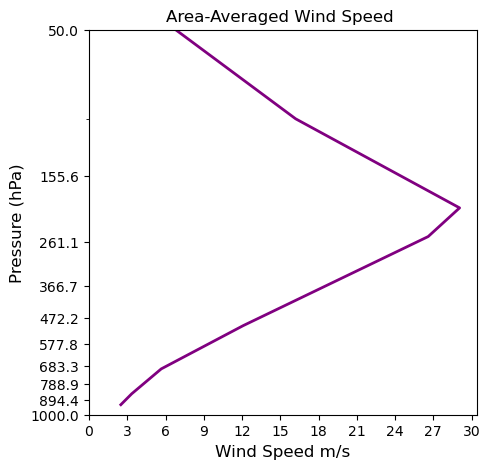

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the data as the area-averaged wind speed
# versus pressure  with plt.plot:
plt.plot(wind_speed, height_1d, color='purple', marker=None, 
         linestyle='solid', linewidth=2)

# set the lower bound on the x-axis to zero (the lowest-
# possible wind speed to be determined by the data).
ax.set_xbound(lower=0, upper=None)

# Get the x-axis' start and end values
xstart, xend = ax.get_xlim()

# set the x-axis tick marks to be every 3 for illustration
ax.xaxis.set_ticks(np.arange(xstart, xend, 3.0))

# Set the y-axis to be logarithmic rather than linear.
ax.set_yscale('symlog')

# Set how the logarithmic axis labels should be structured
# using scalars rather than powers of 10.
ax.yaxis.set_major_formatter(ScalarFormatter())

# Define ten y-axis ticks from 50 to 1000 hPa.
ax.set_yticks(np.linspace(50, 1000, 10))

# Set the y-axis limits - in this case, 1000-100 hPa.
ax.set_ylim(1000., 50.)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Wind Speed m/s", fontsize=12)
ax.set_ylabel("Pressure (hPa)", fontsize=12)

plt.title("Area-Averaged Wind Speed ")
plt.show()
